In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
from itertools import combinations

sns.set_palette('Set2')
pd.options.plotting.backend = 'plotly'

# ignore warnings
import warnings

# Record the starting time
start_time = time.time()

random_state = 42
np.random.seed(random_state)
warnings.filterwarnings('ignore')

In [22]:
df = pd.read_csv('diabetes_prediction_dataset.csv')

df['gender'] = df['gender'].astype('category')
df['smoking_history'] = df['smoking_history'].astype('category')
df['diabetes'] = df['diabetes'].astype(bool)

# drop duplicates
df.drop_duplicates(inplace=True)

# check for duplicates again
print(df.duplicated().any())

X = df.drop('diabetes', axis=1)
y = df.diabetes
X = pd.get_dummies(X, columns=['smoking_history', 'gender'], drop_first=True)
X = X.drop(['gender_Other', 'smoking_history_not current', 'smoking_history_never',
            'smoking_history_ever'], axis=1)

False


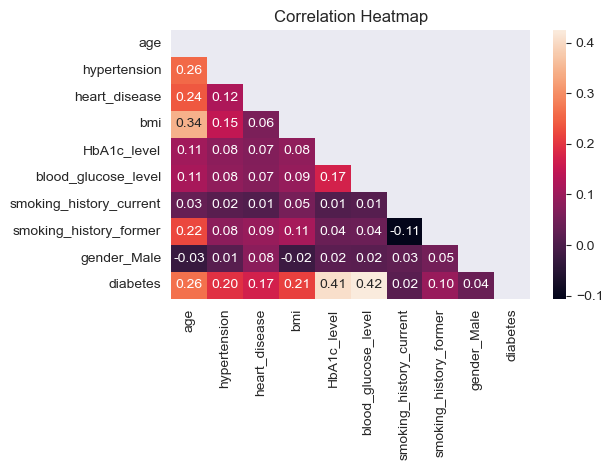

In [23]:
# Correlation Heatmap
corr = pd.concat([X, y], axis=1).corr()

# Create a mask to hide the upper triangle of the heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, mask=mask, fmt='.2f')
plt.title(f'Correlation Heatmap')
plt.tight_layout()
plt.show()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

class_count_0, class_count_1 = y_train.value_counts()
y_train.value_counts().plot(kind='bar', title='count (target)')
plt.show()

# Get the indices of the instances of each class in y_train
indices_majority = y_train[y_train == 0].index
indices_minority = y_train[y_train == 1].index

# Calculate the desired number of samples in the majority class
desired_majority_count = 4 * len(indices_minority)

# Randomly undersample the majority class to get the desired number of samples
undersampled_indices = np.random.choice(indices_majority, size=desired_majority_count, replace=False)

# Combine the undersampled majority indices and the minority indices
balanced_indices = np.concatenate([undersampled_indices, indices_minority])

# Use the balanced_indices to get the balanced X_train and y_train
X_train = X_train.loc[balanced_indices]
y_train = y_train.loc[balanced_indices]

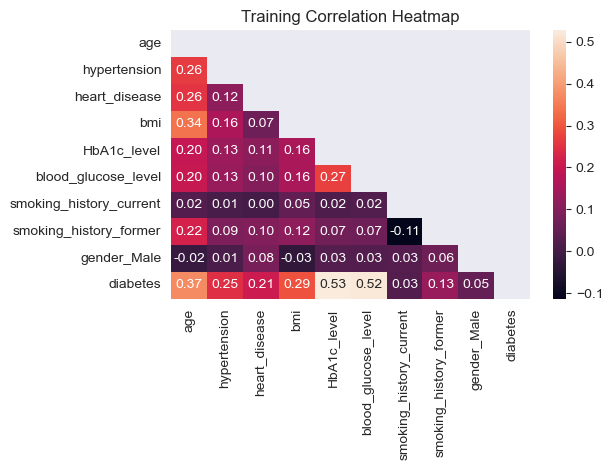

In [25]:
# Correlation Heatmap
corr = pd.concat([X_train, y_train], axis=1).corr()

# Create a mask to hide the upper triangle of the heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, mask=mask, fmt='.2f')
plt.title(f'Training Correlation Heatmap')
plt.tight_layout()
plt.show()

the accuracy on train set 0.95870433367845
the accuracy on test set 0.9598023920956839

              precision    recall  f1-score   support

       False       0.98      0.98      0.98     17509
        True       0.79      0.76      0.77      1721

    accuracy                           0.96     19230
   macro avg       0.88      0.87      0.87     19230
weighted avg       0.96      0.96      0.96     19230



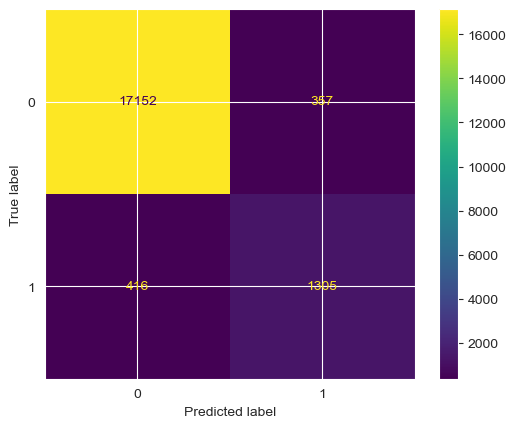

In [26]:
model = XGBClassifier(n_estimators=100, random_state=random_state)
model.fit(X_train, y_train)
cv = 5
weights = [2, 3, 25, 50, 100, 500]

y_train_repo = model.predict(X_train)
y_test_repo = model.predict(X_test)
print(f"the accuracy on train set {accuracy_score(y_train, y_train_repo)}")
print(f"the accuracy on test set {accuracy_score(y_test, y_test_repo)}")
print()
print(classification_report(y_test, y_test_repo))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_repo)).plot()
plt.show()

In [20]:
# Compute SHAP values and plot summary
samples = 998
X_shap = shap.sample(X_test, samples, random_state=random_state)
mask = shap.maskers.Independent(X_train, max_samples=1000)
X_shap = X_shap.append([X_test.iloc[2,:], X_test.iloc[39,:]])
explainer = shap.KernelExplainer(model.predict, X_shap, masker=mask)

shap_values = explainer.shap_values(X_shap)

explanation = shap.Explanation(shap_values, base_values=np.repeat(explainer.expected_value,len(shap_values)),
                               data=X_shap, feature_names=X_test.columns)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

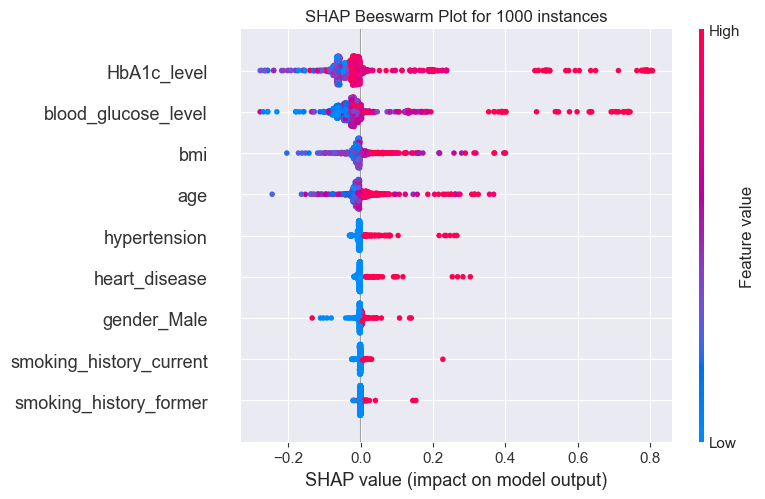

In [8]:
# Beeswarm SHAP Plot
shap.plots.beeswarm(explanation, show=False)
plt.title(f'SHAP Beeswarm Plot for {samples} instances')
plt.tight_layout()
plt.savefig('beeswarm_SHAP.png')
plt.show()


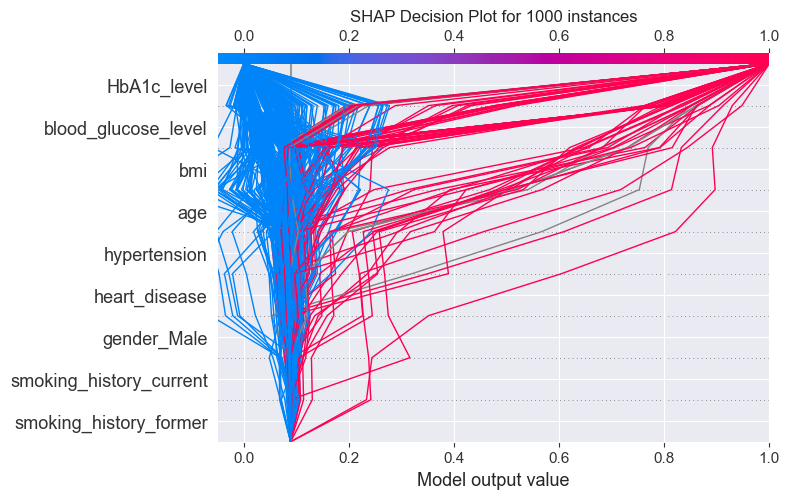

In [9]:
# Decision plot SHAP
shap.decision_plot(explainer.expected_value, shap_values,
                   feature_names=list(X_train.columns), xlim=(-0.05, 1), show=False)
plt.title(f'SHAP Decision Plot for {samples} instances')
plt.tight_layout()
plt.savefig('dec_SHAP.png')
plt.show()


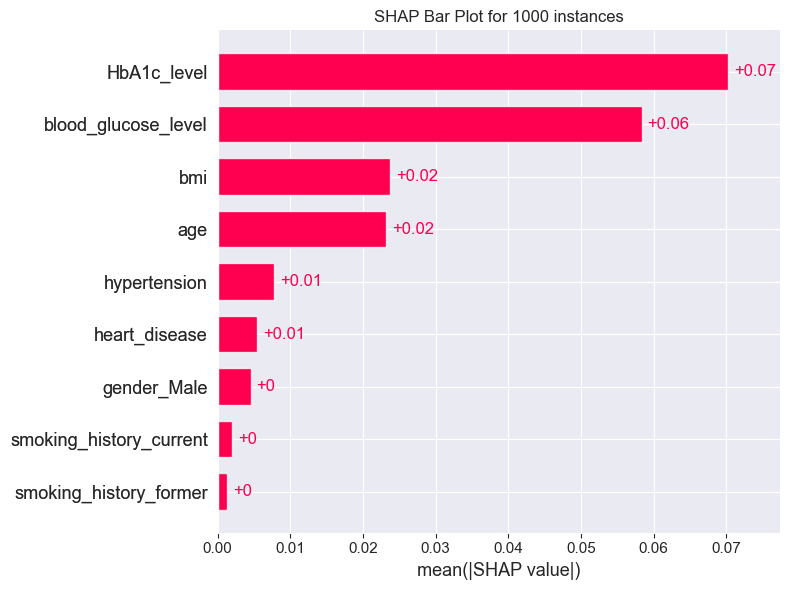

In [10]:
# Mean Bar Plot SHAP
shap.plots.bar(explanation, show=False)
plt.title(f'SHAP Bar Plot for {samples} instances')
plt.tight_layout()
plt.savefig('bar_SHAP.png')
plt.show()


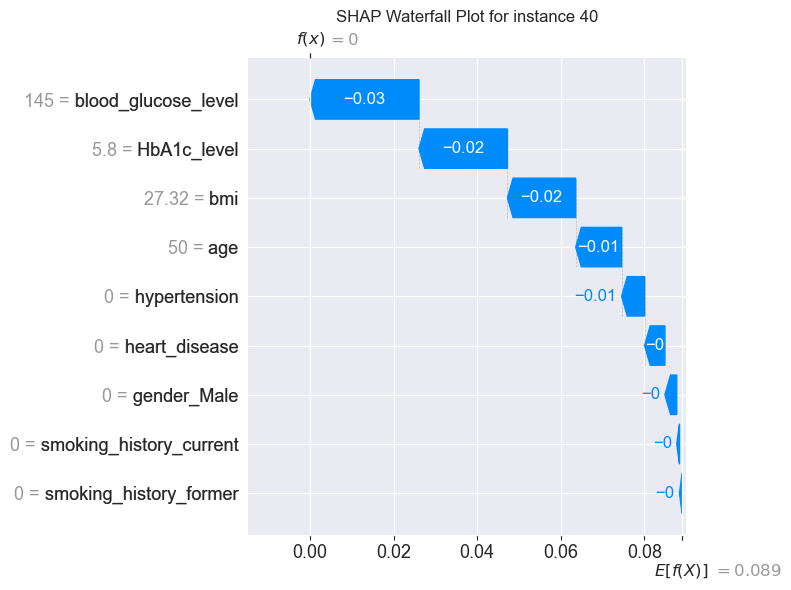

In [11]:
# Single Instance Waterfall plot
# Compute SHAP values and plot summary
instance_no = 40

shap.plots.waterfall(explanation[instance_no - 1], show=False)
plt.title(f'SHAP Waterfall Plot for instance {instance_no}')
plt.tight_layout()
plt.savefig(f'wf_SHAP_{instance_no}.png')
plt.show()

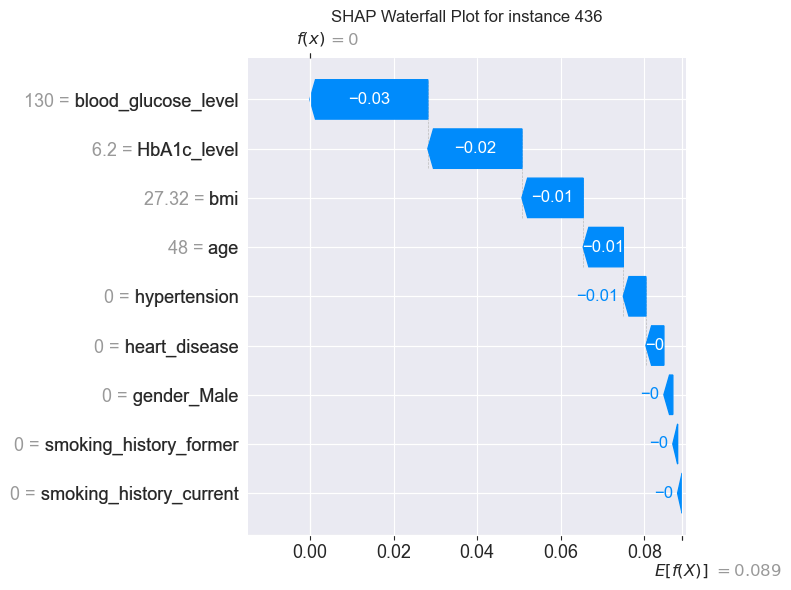

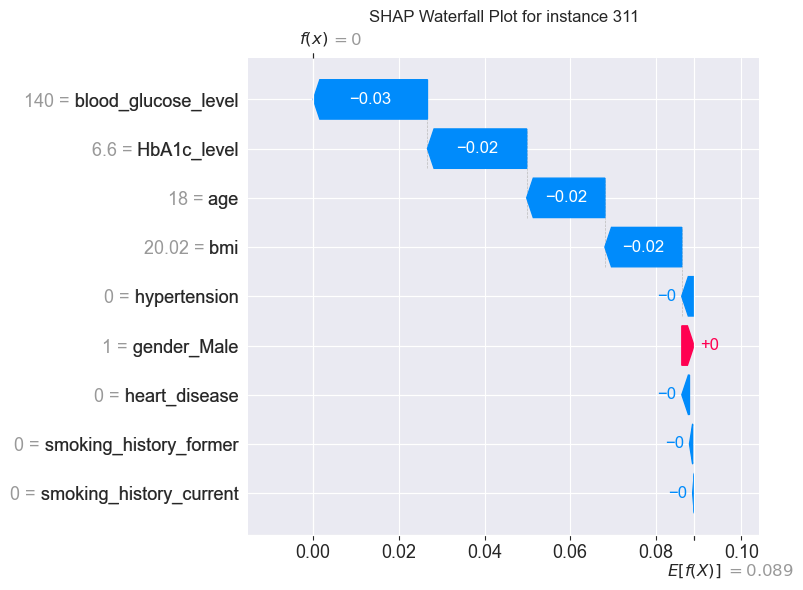

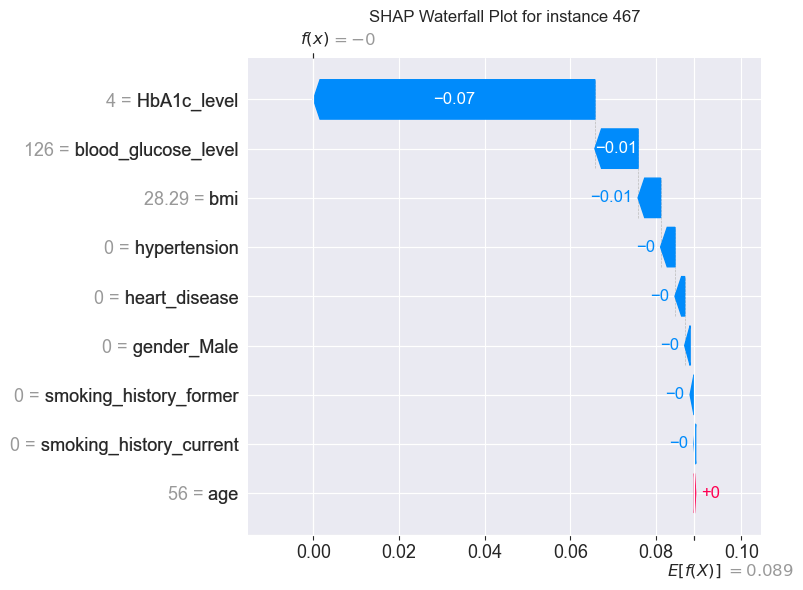

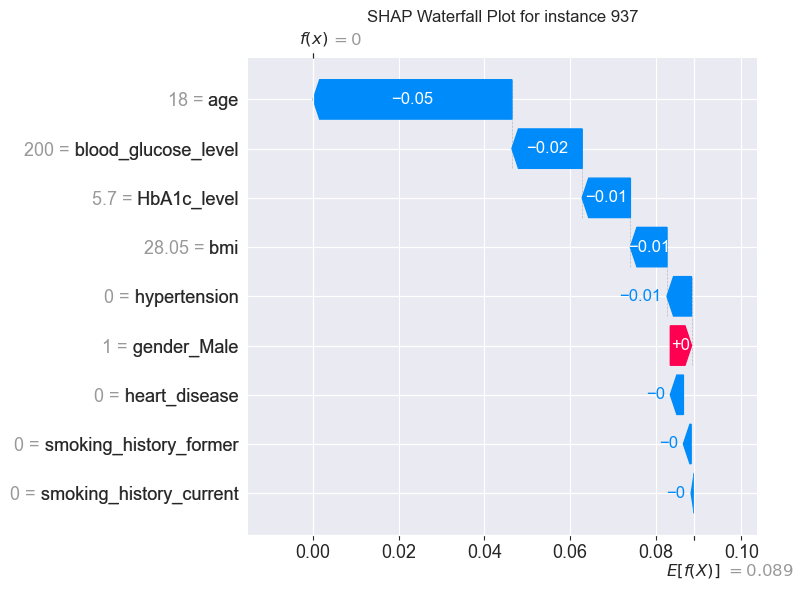

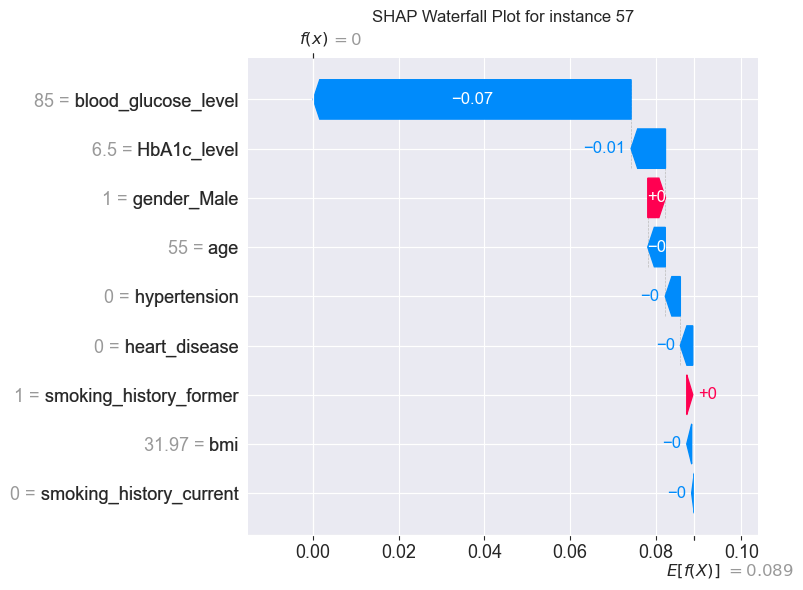

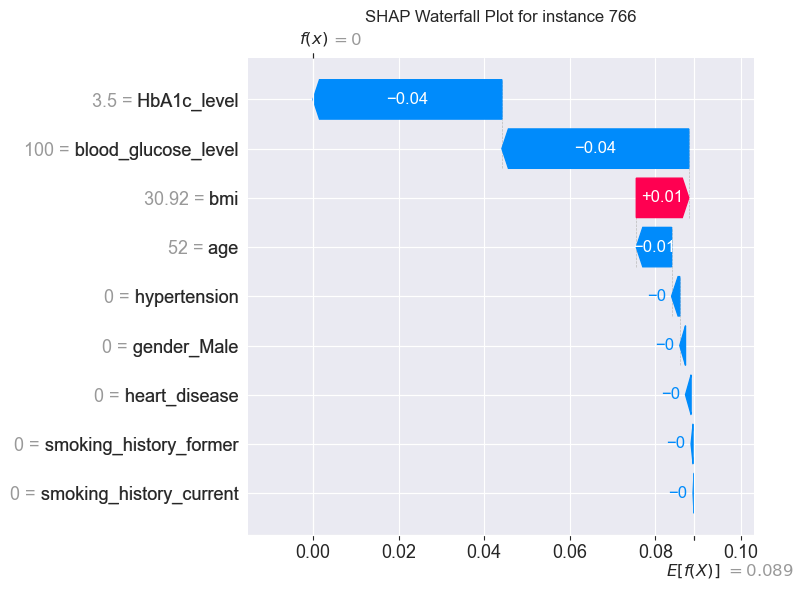

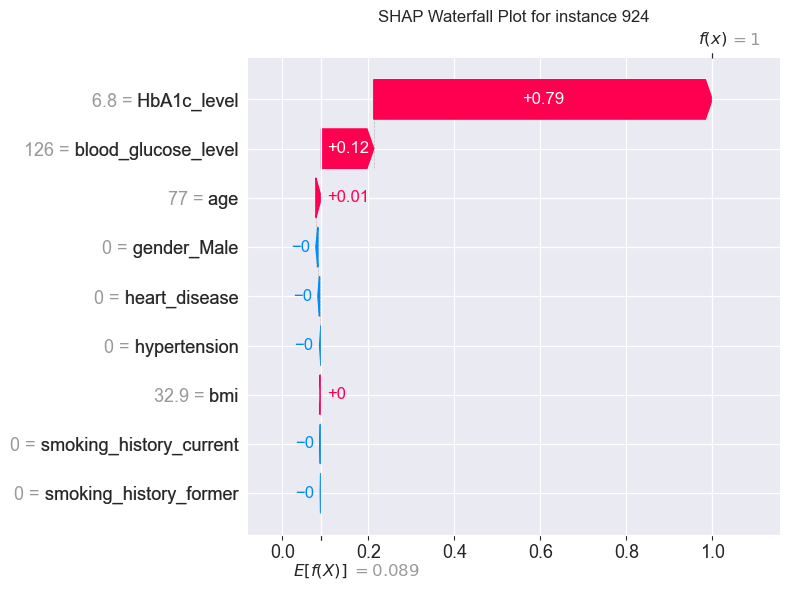

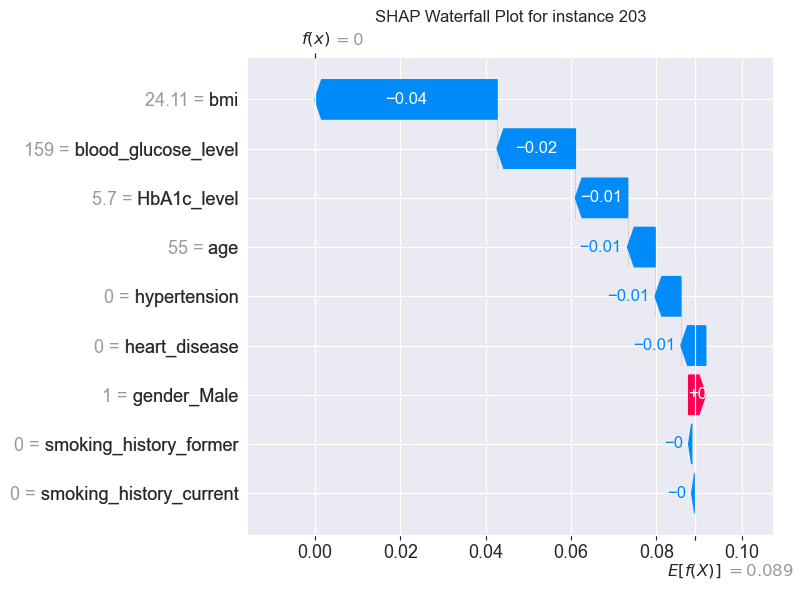

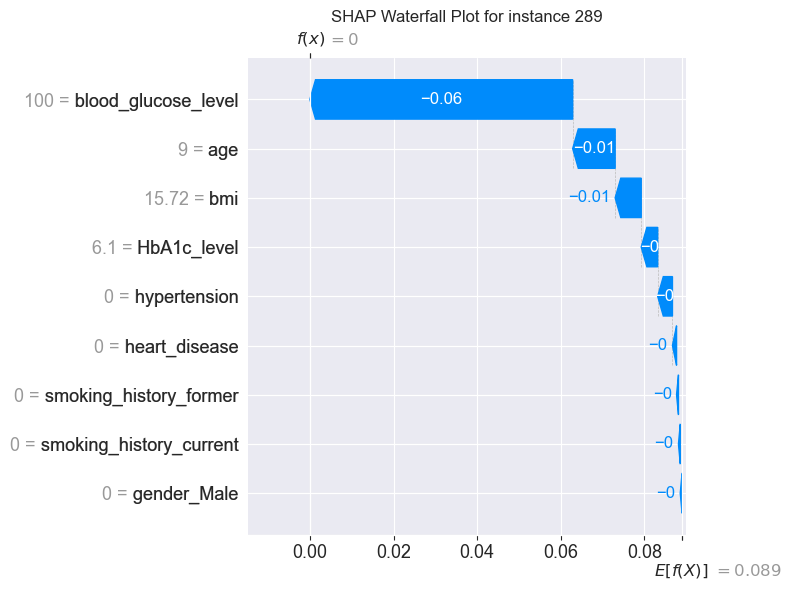

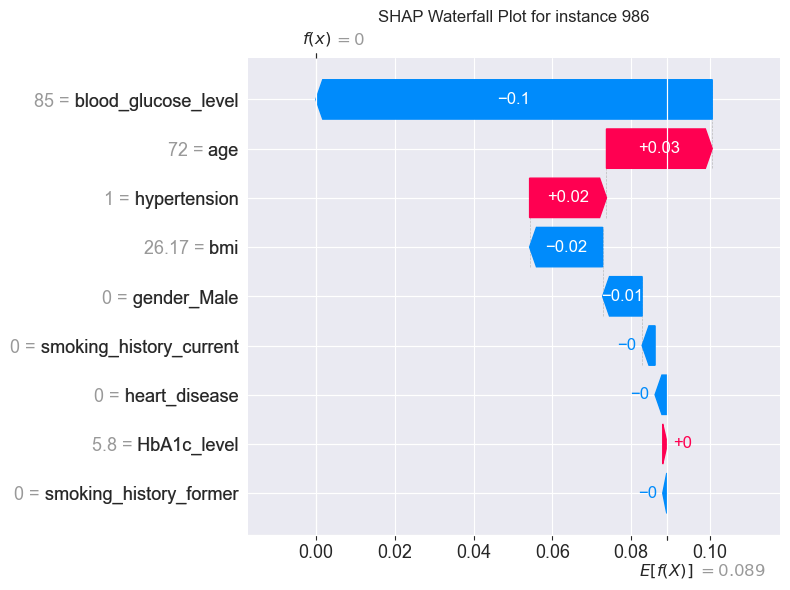

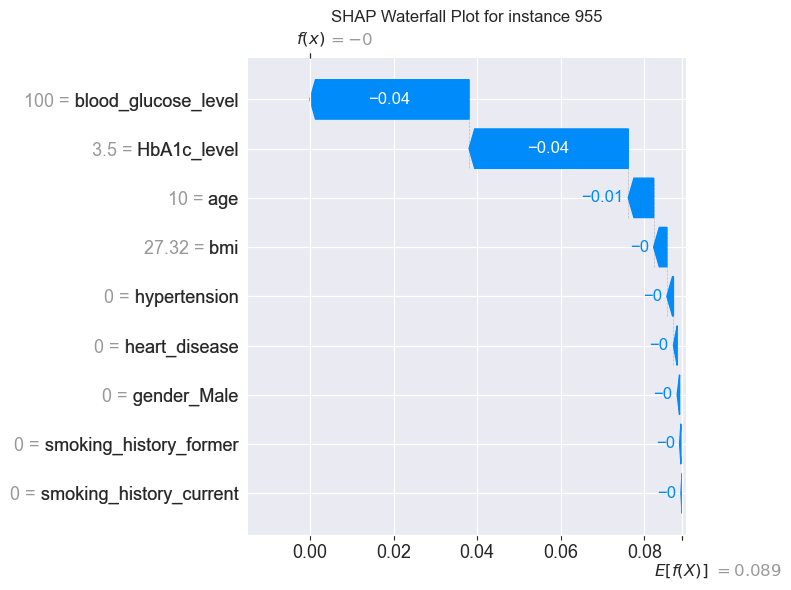

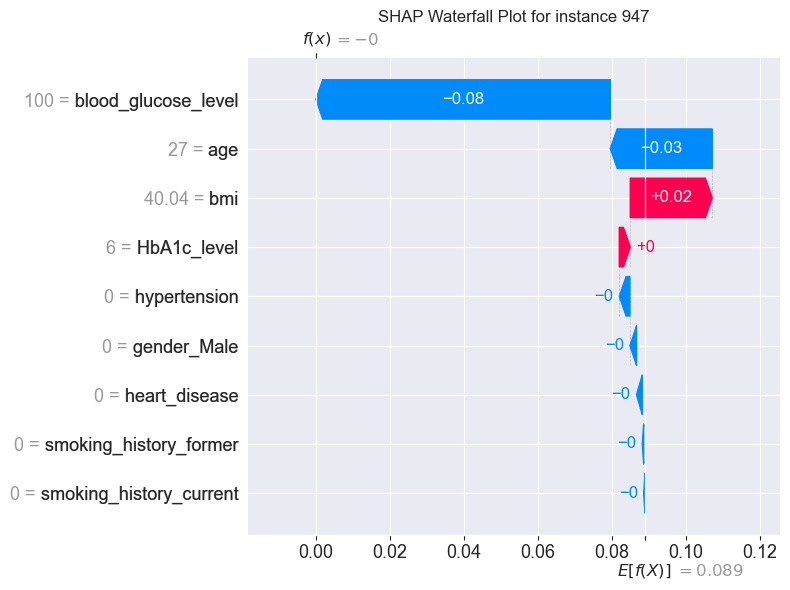

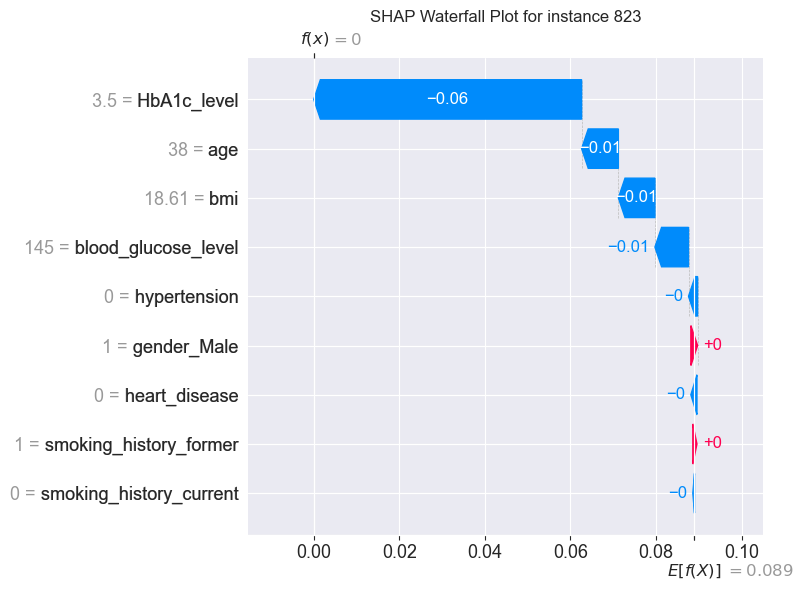

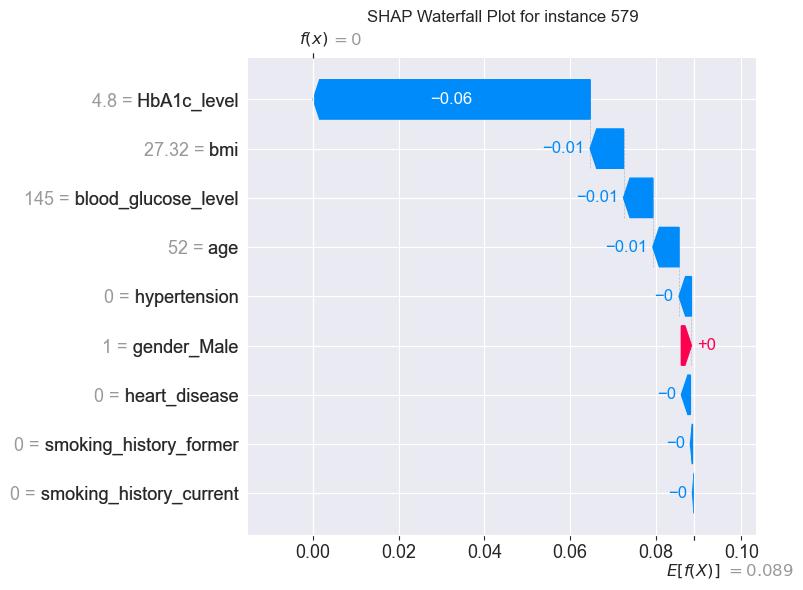

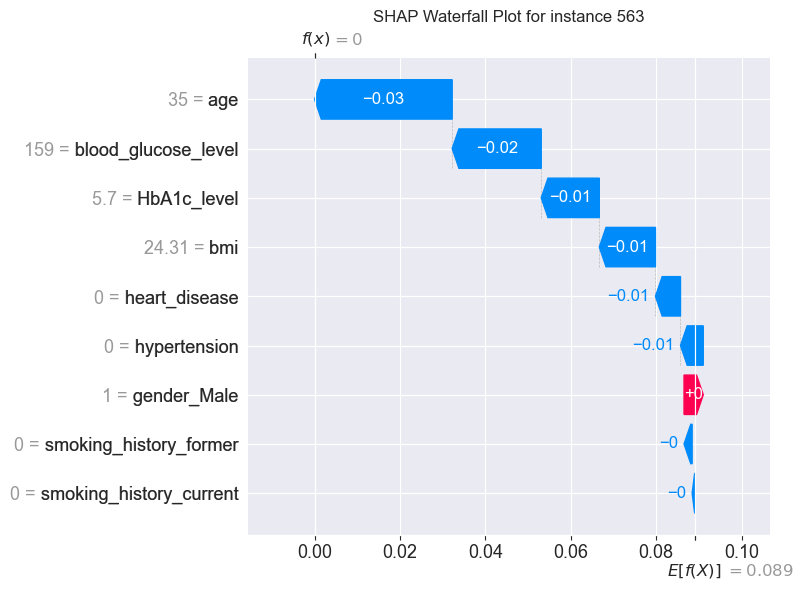

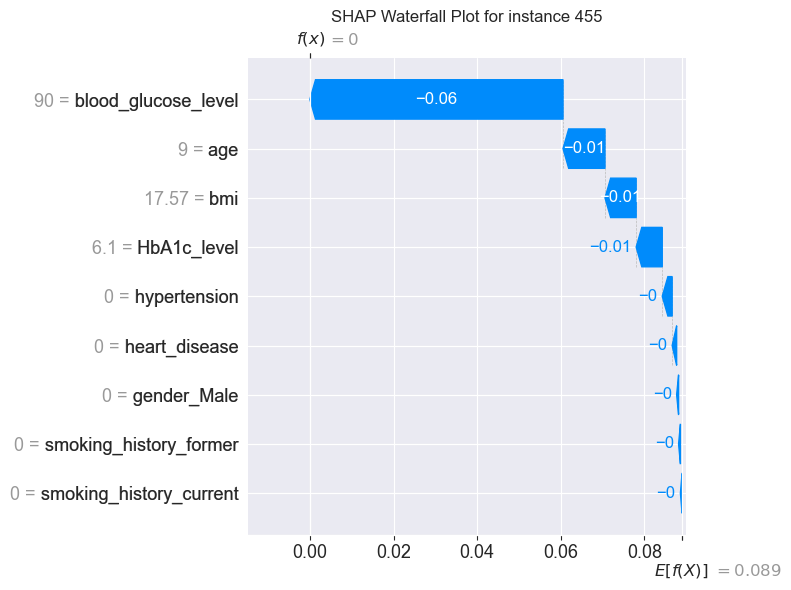

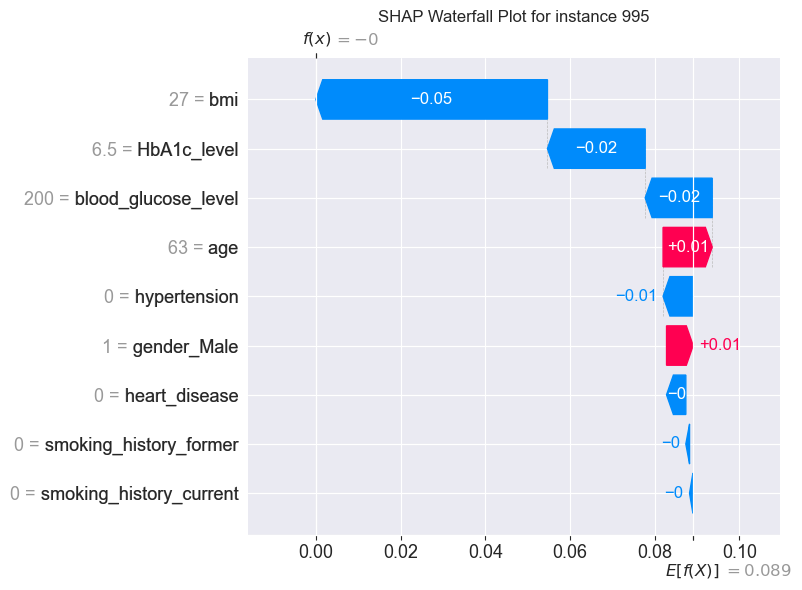

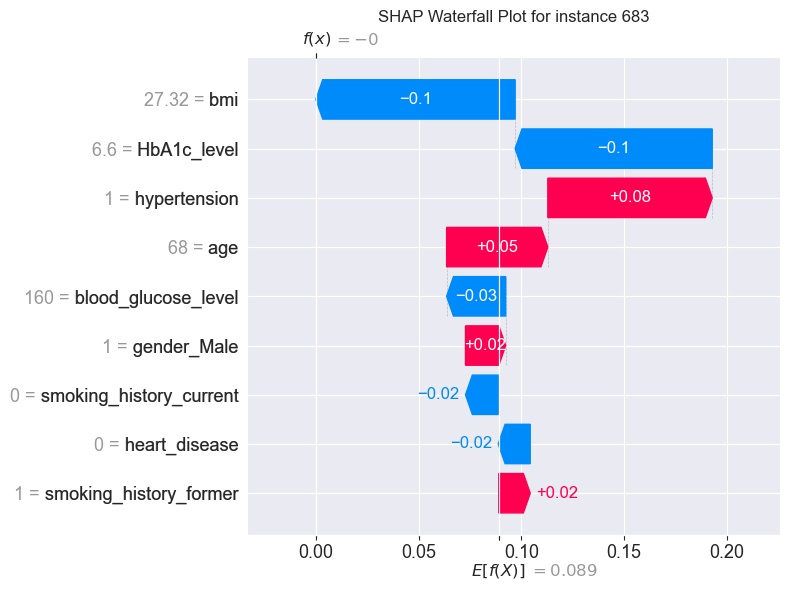

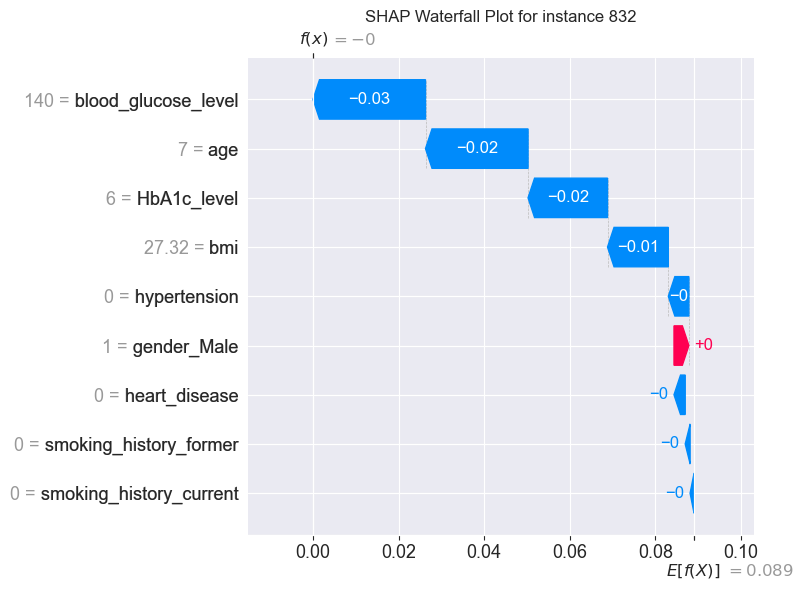

In [12]:
# Multiple Instance Waterfall
instances = 19
instance_nos = np.random.choice(range(1, samples + 1), instances, replace=False)
for i in instance_nos:
    shap.plots.waterfall(explanation[i - 1], show=False)
    plt.title(f'SHAP Waterfall Plot for instance {i}')
    plt.tight_layout()
    plt.savefig(f'wf_SHAP_{i}.png')
    plt.show()

In [13]:
# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Print the runtime in seconds
print(f"Runtime: {elapsed_time:.2f}s")

Runtime: 2002.80s


In [33]:
y_test.iloc[2]

True